Submitted by: Josh, Caleb, Yetti

# Project Overview

This project aims to predict the future allocation of funds to states and territories who experience natural disasters through Time Series Analysis.


## Problem Statement
---
Natural disasters can strike at a moment's notice, leaving little to no time for adequate preparations to be made. This leaves quite the large chore of cleanup and eventually recovery to get back to life as normal. From tornadoes to floods, earthquakes to pandemics, a community can be ravaged and left, literally, out in the cold if recovery costs are not met.

We are working for FEMA on a team that is preparing next year's budget. We have been tasked to present forecasts of funds needed in future disaster recovery scenarios, such that all future funding can be optimized.

**Based on past budgeting and past natural disasters , can we optimize a model to predict the future allocated budget for future disasters?**

In [1]:
import pandas as pd, datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')
from math import sqrt

##  Data Imports and EDA

We will be exploring the 10 year data with the inclusion of Covid. We want to see the trends and changes in funding from the years (beginning) 2011 - (end) 2020.

In [2]:
df_10 = pd.read_csv('./data/10-year-covid.csv')
df_10.head()

,Unnamed: 0,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,totalObligated
0,462426,1952,2011-01-26 05:00:00+00:00,Flood,CBMIB01 - BIA Roads - Emergency Protective Mea...,B - Protective Measures,Small,California,CA,3893.00,2919.75,2919.75
1,462427,1952,2011-01-26 05:00:00+00:00,Flood,LJIRA01 - Debris Removal - 88 Culverts and Veg...,A - Debris Removal,Small,California,CA,45936.76,34452.57,34452.57
2,462428,1952,2011-01-26 05:00:00+00:00,Flood,PBMIE01 - Flood Waters Damaged Casino,E - Public Buildings,Small,California,CA,3263.00,2447.25,2447.25
3,462429,1952,2011-01-26 05:00:00+00:00,Flood,RCIR-01 - Seven Sites - Roads and Slope Damage,C - Roads & Bridges,Small,California,CA,10602.25,7951.69,7951.69
4,462430,1952,2011-01-26 05:00:00+00:00,Flood,SMR25- Old Highland Canal-Debris Removal,A - Debris Removal,Small,California,CA,19214.59,14410.94,14410.94


In [3]:
#Making a year column to better see when disater funds are allocated
df_10['year'] = [int(i[0:4]) for i in df_10['declarationDate']]
df_10['month'] = [int(i[5:7]) for i in df_10['declarationDate']]

df_10 = df_10[[c for c in df_10 if c not in ['totalObligated']] + ['totalObligated']]

df_10.head(3)

,Unnamed: 0,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,year,month,totalObligated
0,462426,1952,2011-01-26 05:00:00+00:00,Flood,CBMIB01 - BIA Roads - Emergency Protective Mea...,B - Protective Measures,Small,California,CA,3893.00,2919.75,2011,1,2919.75
1,462427,1952,2011-01-26 05:00:00+00:00,Flood,LJIRA01 - Debris Removal - 88 Culverts and Veg...,A - Debris Removal,Small,California,CA,45936.76,34452.57,2011,1,34452.57
2,462428,1952,2011-01-26 05:00:00+00:00,Flood,PBMIE01 - Flood Waters Damaged Casino,E - Public Buildings,Small,California,CA,3263.00,2447.25,2011,1,2447.25


In [4]:
#A function to do some light processing
def process_data(data):
    data['declarationDate'] = pd.to_datetime(data['declarationDate'])
    data.set_index('declarationDate', inplace=True)
    print(data.info()) #this displays the dataframe's info
    print(f' Nan values: {data.isna().sum().sum()}') #displays the sum of Nan values
    print(data.shape) #prints the shape
    

In [152]:
process_data(df_10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237369 entries, 2011-01-26 05:00:00+00:00 to 2020-10-16 04:00:00+00:00
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             237369 non-null  int64  
 1   disasterNumber         237369 non-null  int64  
 2   incidentType           237369 non-null  object 
 3   applicationTitle       237369 non-null  object 
 4   damageCategoryCode     237369 non-null  object 
 5   projectSize            237369 non-null  object 
 6   state                  237369 non-null  object 
 7   stateCode              237369 non-null  object 
 8   projectAmount          237369 non-null  float64
 9   federalShareObligated  237369 non-null  float64
 10  year                   237369 non-null  int64  
 11  month                  237369 non-null  int64  
 12  totalObligated         237369 non-null  float64
dtypes: float64(3), int64(4), object(6)
memory u

In [153]:
#Sorting by amount allocated to each region/ territory
df_10_sorted = df_10.sort_values('totalObligated')
df_10_sorted.tail(3)

,Unnamed: 0,disasterNumber,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,year,month,totalObligated
declarationDate,,,,,,,,,,,,,
2020-03-25 04:00:00+00:00,719750,4485,Biological,144261 - COVID-19 Medical Surge Staffing,B - Protective Measures,Large,Texas,TX,4.527483e+09,3.395613e+09,2020,3,3.395613e+09
2017-09-20 04:00:00+00:00,727328,4339,Hurricane,144184 - MAAA200 Puerto Rico Aqueduct and Sewe...,F - Public Utilities,Large,Puerto Rico,PR,4.069699e+09,3.662729e+09,2017,9,3.662729e+09
2017-09-20 04:00:00+00:00,719349,4339,Hurricane,136271 - MEPA078 Puerto Rico Electrical Power ...,F - Public Utilities,Large,Puerto Rico,PR,1.051098e+10,9.459885e+09,2017,9,9.459885e+09


In [154]:
display(df_10.disasterNumber.nunique())

645

### Visualizations
---
Visualizing features of the data to better understand our dataset.

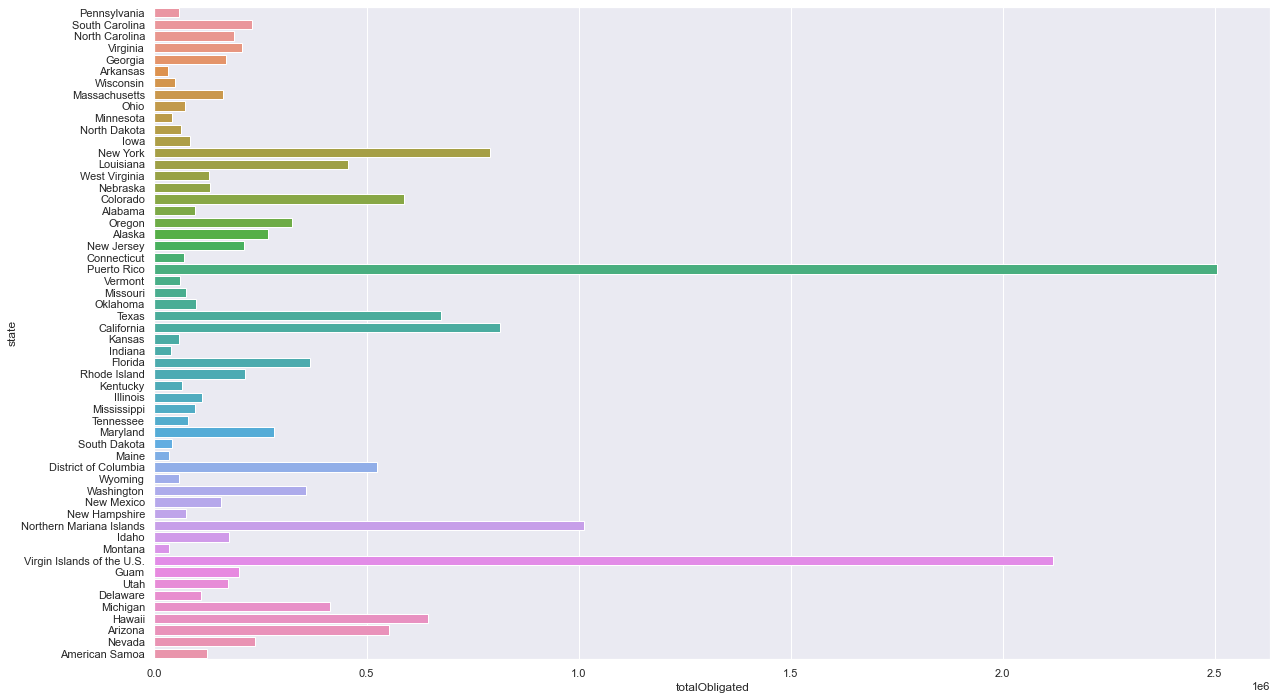

In [155]:
#Visualizing the amount of money given to each state and territory.
#Puerto Rico has had the most money given over the past 10 years.

bar,ax = plt.subplots(figsize=(20,12))
ax = sns.barplot(x="totalObligated", 
                 y="state", 
                 data=df_10_sorted, 
                 ci=None, 
                 orient='h'
                )

plt.show()

In [6]:
#We are splitting the states/territories up by regions so that we can
#better visualize the funds allocated for disaster relief. This is only for purposes to understand
#our data. These regions will ultimately be recombined during our modeling, since we are looking
#at overall FEMA Funding for the US and territories.
#Regionalize the U.S.
w_states = ['AK', 'HI', 'WA', 'CA', 'OR', 'ID', 'NV', 'MT', 'UT', 'AZ', 'CO', 'WY', 'NM']
s_states = ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'FL', 'GA', 'SC', 'NC', 'TN', 'KY', 'VA', 'WV']
mw_states = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'IL', 'WI', 'MI', 'IN', 'OH']
ne_states = ['ME', 'NH', 'VT', 'NY', 'MA', 'CT', 'RI', 'PA', 'NJ', 'DE', 'MD', 'DC']
terr_country = ['PR', 'AS', 'GU', 'MP', 'VI']

In [7]:
#We've created smaller dataframes for each region

west = df_10.loc[df_10['stateCode'].isin(w_states)].copy()
south = df_10.loc[df_10['stateCode'].isin(s_states)].copy()
midwest = df_10.loc[df_10['stateCode'].isin(mw_states)].copy()
northeast = df_10.loc[df_10['stateCode'].isin(ne_states)].copy()
territory = df_10.loc[df_10['stateCode'].isin(terr_country)].copy()

#Printing the total sum for obligated funds per region/territory
print(round(sum(west['totalObligated']), 2))
print(round(sum(south['totalObligated']), 2)) #second highest in funds delivered
print(round(sum(midwest['totalObligated']), 2))
print(round(sum(northeast['totalObligated']), 2))
print(round(sum(territory['totalObligated']), 2)) #territories have the highest in funds delivered overall

8644210733.0
22346005467.88
4027227297.87
23575278511.98
27023418209.79


In [158]:
#Seeing what our dataframes look like.
west.tail(2)

,Unnamed: 0,disasterNumber,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,year,month,totalObligated
declarationDate,,,,,,,,,,,,,
2020-10-16 04:00:00+00:00,732338,4569,Fire,161677 - Emergency Protective Measures Perform...,B - Protective Measures,Small,California,CA,92138.0,69103.50,2020,10,69103.50
2020-10-16 04:00:00+00:00,732339,4569,Fire,161500 - Activate Emergency Operations Center,B - Protective Measures,Small,California,CA,18690.5,14017.88,2020,10,14017.88


In [8]:
west_top = west['totalObligated'].sort_values()
west_top.tail()

234139    2.749553e+08
164071    4.616074e+08
216294    4.686548e+08
202872    4.914622e+08
234263    5.086747e+08
Name: totalObligated, dtype: float64

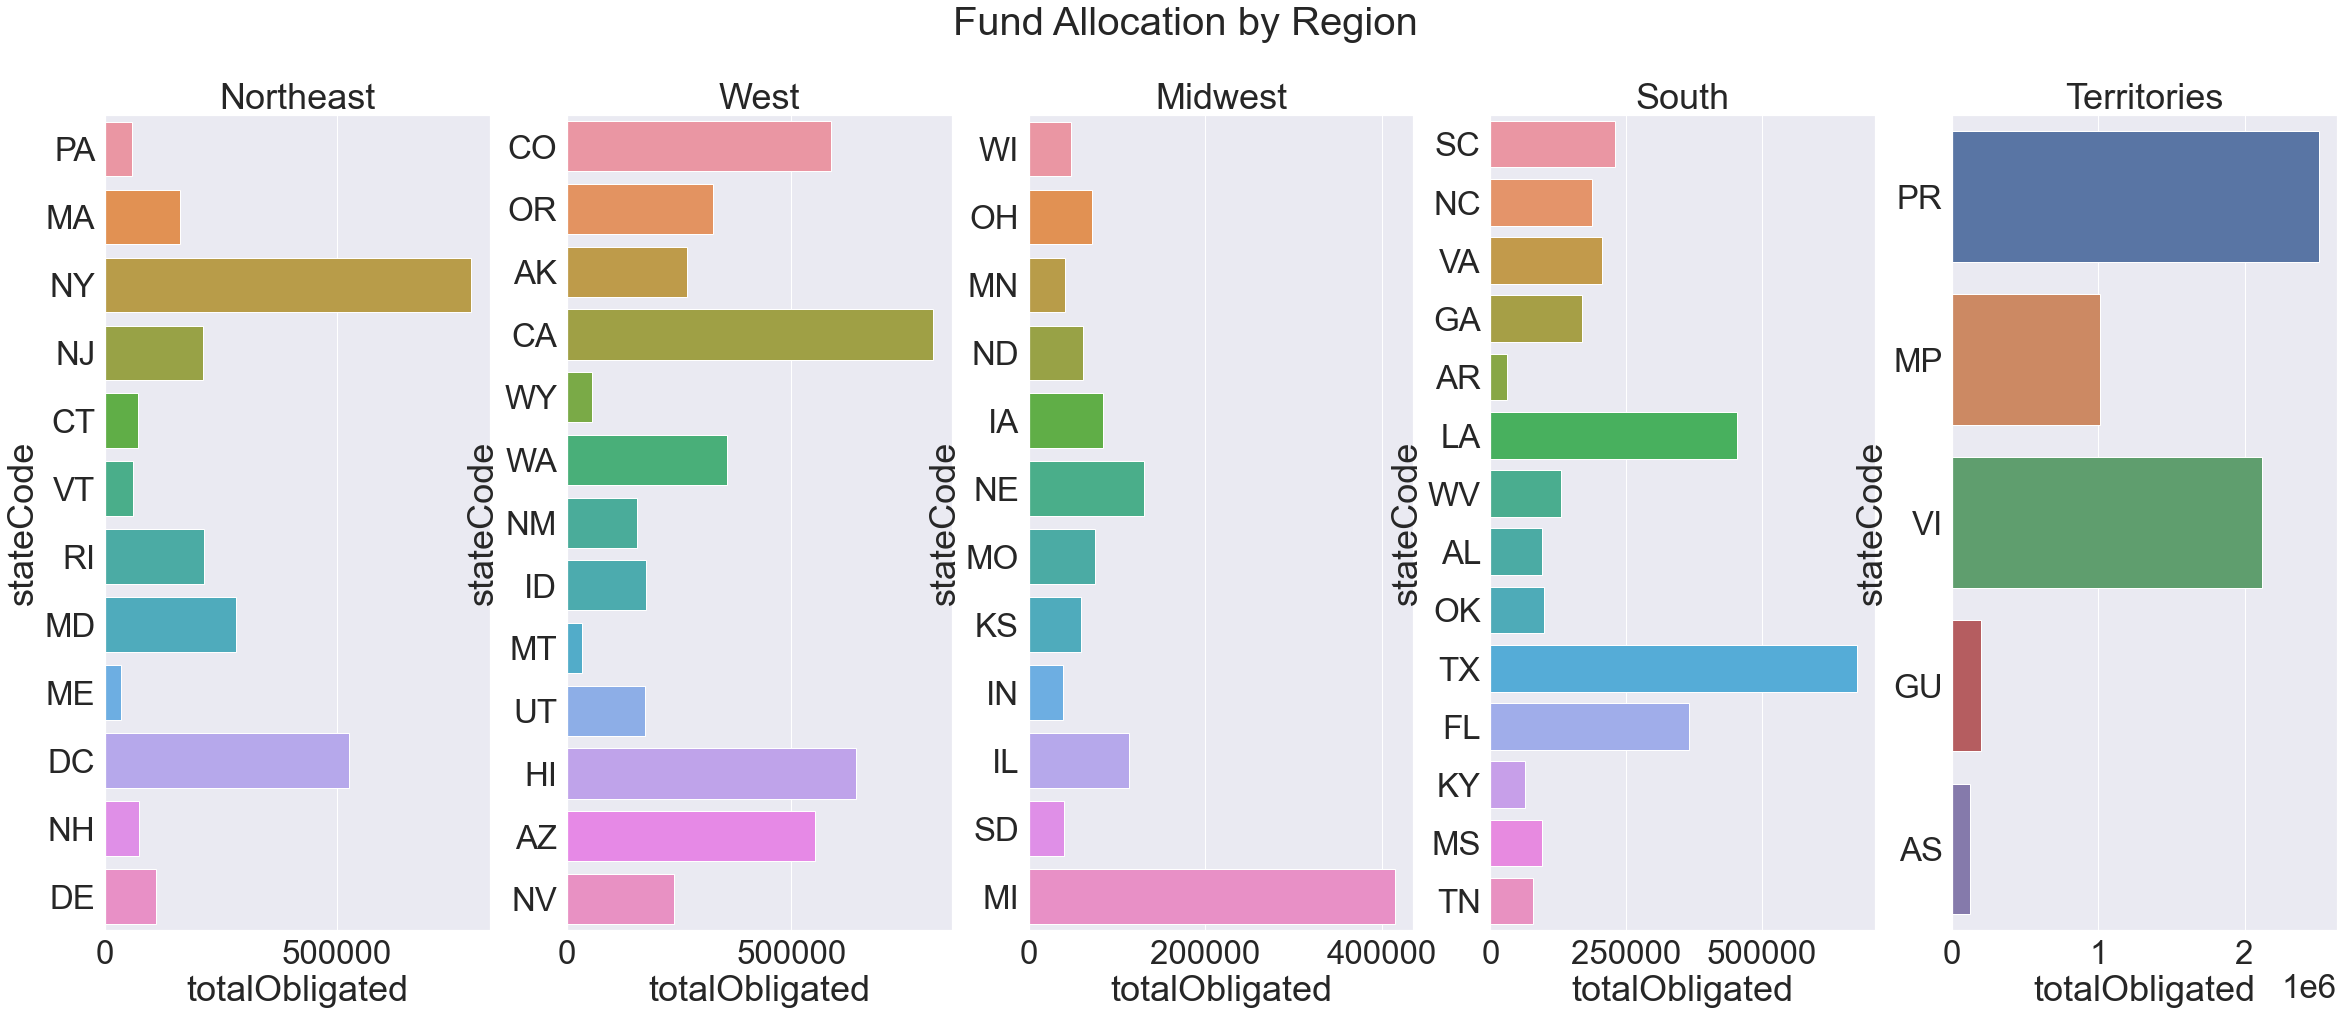

In [10]:
#Plotting fund allocation by region and territory

fig, axes = plt.subplots(1, 5, figsize=(40, 15))
fig.suptitle('Fund Allocation by Region', size=40)


sns.barplot(ax=axes[0], x="totalObligated", y="stateCode",
            data=northeast.sort_values('totalObligated'), ci=None, orient= 'h')
axes[0].set_title('Northeast')

sns.barplot(ax=axes[1], x="totalObligated", y="stateCode",
            data=west.sort_values('totalObligated'), ci=None, orient= 'h' )
axes[1].set_title('West')

sns.barplot(ax=axes[2], x="totalObligated", y="stateCode",
            data=midwest.sort_values('totalObligated'), ci=None, orient= 'h')
axes[2].set_title('Midwest')

sns.barplot(ax=axes[3], x="totalObligated", y="stateCode",
            data=south.sort_values('totalObligated'), ci=None, orient= 'h')
axes[3].set_title('South')

sns.barplot(ax=axes[4], x="totalObligated", y="stateCode",
           data=territory.sort_values('totalObligated'), ci=None, orient= 'h')
axes[4].set_title('Territories')
sns.set(font_scale = 3)


### Insights
---
We see that the territories and the southern region have the highest allocation of budget. Now we will look at what money went to which area of disaster for each region.

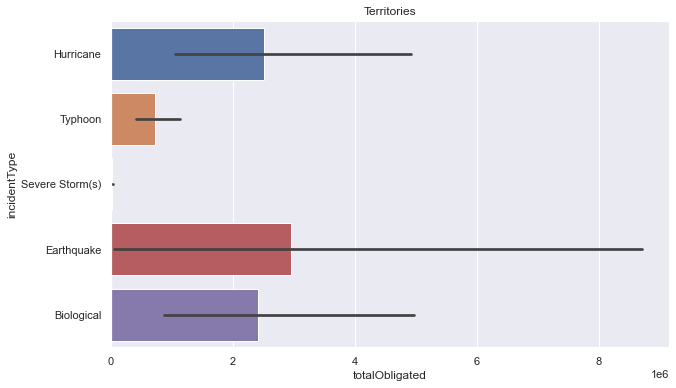

In [161]:
# territories
#we are plotting the funds allocated by disaster for each region.
#in order not to skew the scale. territory was done first.
sns.set(font_scale = 1)
bar,ax = plt.subplots(figsize=(10,6))

ax = sns.barplot( x="totalObligated", y="incidentType",
            data=territory.sort_values('totalObligated'))
ax.set_title('Territories')
plt.show()

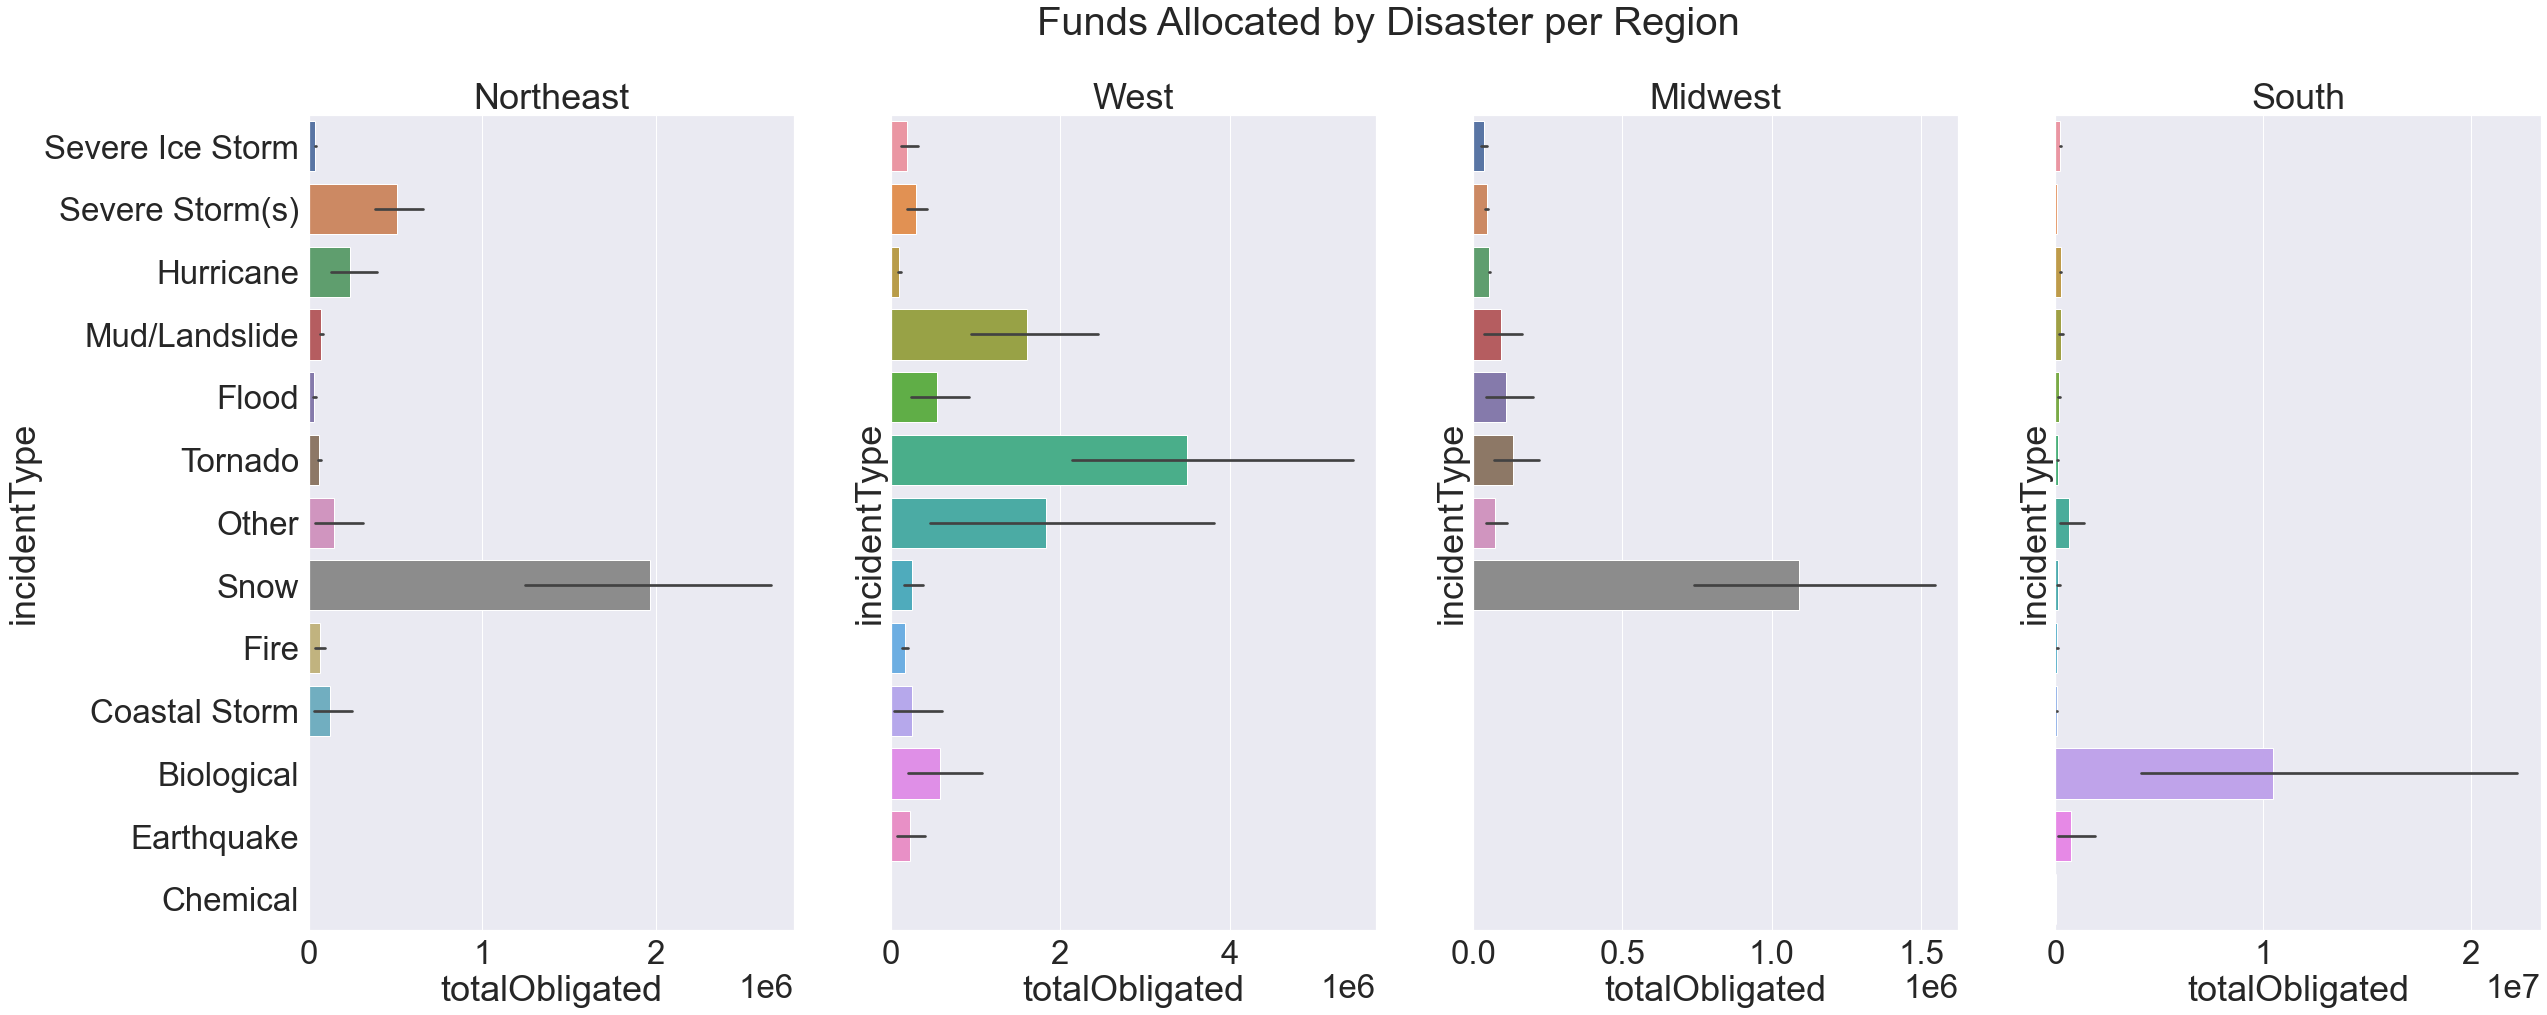

In [11]:

fig, axes = plt.subplots(1, 4, figsize=(40, 15), sharey=True)
fig.suptitle('Funds Allocated by Disaster per Region', size=40)


sns.barplot(ax=axes[0], x="totalObligated", y="incidentType",
            data=northeast.sort_values('totalObligated'))
axes[0].set_title('Northeast')

sns.barplot(ax=axes[1], x="totalObligated", y="incidentType",
            data=west.sort_values('totalObligated') )
axes[1].set_title('West')

sns.barplot(ax=axes[2], x="totalObligated", y="incidentType",
            data=midwest.sort_values('totalObligated'))
axes[2].set_title('Midwest')

sns.barplot(ax=axes[3], x="totalObligated", y="incidentType",
            data=south.sort_values('totalObligated'))
axes[3].set_title('South')
sns.set(font_scale = 3)

### Insights
---
The territories had allocations of funds higest in earthquakes, biological disasters and hurricanes. The northeast and midwest had highest allocations for snow, and the west had the highest fund allocation for tornados. The south had the highest fund allocation for biological events.

We can discern where most of our money will go in the event of a disater for each region.

### Factorplot Visualization

Visualizing the spending per incident per year for each region and also visualizing the trend in disaster aid by each month for each year.

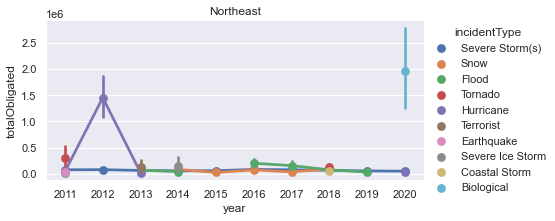

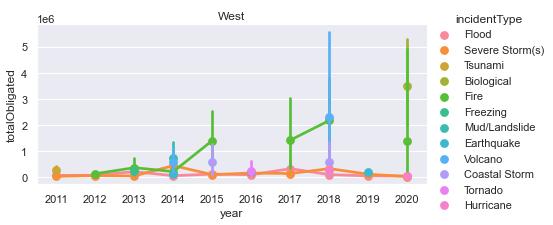

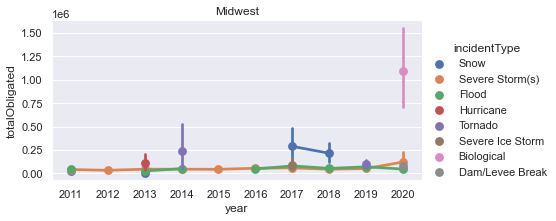

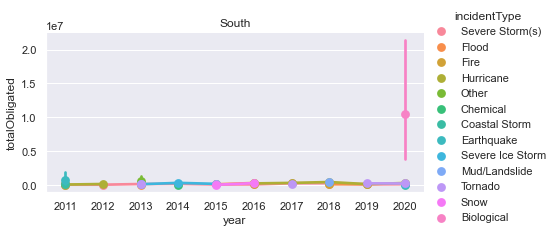

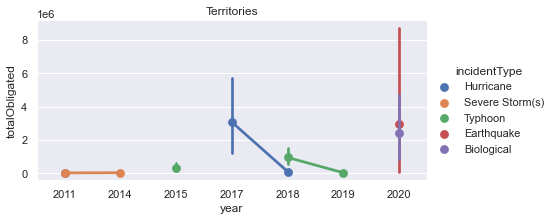

In [163]:
#Plotting the trend in spending per disaster for each region.


sns.set(font_scale = 1)
sns.factorplot(x="year", y="totalObligated", 
               hue = 'incidentType', 
               data=northeast,  size=3, aspect=2)
plt.title('Northeast')

sns.factorplot(x="year", y="totalObligated", 
               hue = 'incidentType', data=west, size=3, aspect=2)
plt.title('West')

sns.factorplot(x="year", y="totalObligated", 
               hue = 'incidentType',
               data=midwest, size=3, aspect=2)
plt.title('Midwest')

sns.factorplot(x="year", y="totalObligated", 
               hue = 'incidentType',
               data=south, size=3, aspect=2)
plt.title('South')

sns.factorplot(x="year", y="totalObligated", 
               hue = 'incidentType',
               data=territory, size=3, aspect=2)
plt.title('Territories')

plt.show()

### Insights
---
Spending for every region/ territory went down or stayed fairly low until 2020,
Which can be attributed to Covid. The spikes showing in some regions are consistent with catestrophic events that were extremely impactful for that year.

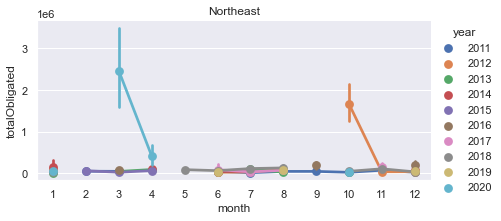

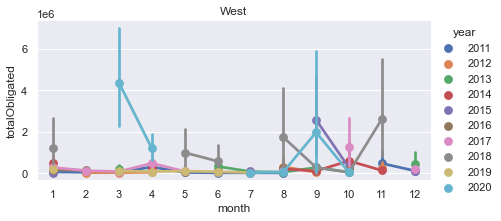

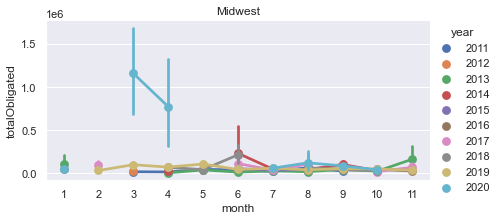

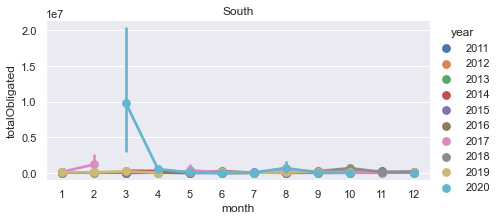

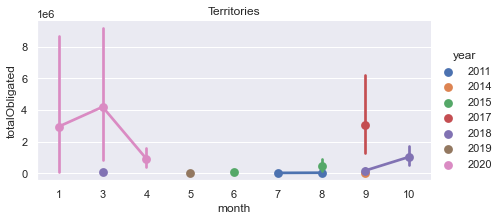

In [164]:
#Plotting the trend in spending for each year by month.

sns.set(font_scale = 1)
sns.factorplot(x="month", y="totalObligated", 
               hue = 'year', 
               data=northeast,  size=3, aspect=2)
plt.title('Northeast')

sns.factorplot(x="month", y="totalObligated", 
               hue = 'year', data=west, size=3, aspect=2)
plt.title('West')

sns.factorplot(x="month", y="totalObligated", 
               hue = 'year',
               data=midwest, size=3, aspect=2)
plt.title('Midwest')

sns.factorplot(x="month", y="totalObligated", 
               hue = 'year',
               data=south, size=3, aspect=2)
plt.title('South')

sns.factorplot(x="month", y="totalObligated", 
               hue = 'year',
               data=territory, size=3, aspect=2)
plt.title('Territories')


plt.show()

In [165]:
#The above graphs shows that fund distribution peaked in the year 2020 during the month of March.
#We see that there is no real seasonality throughout the years of funds being spent.

In [166]:
#Function to test stationarity by disaster for each region/ territory
#We will use this to spot check certain disasters with certain regions.

def test_stationarity(region, disaster_event):
    
    region['totalObligated'] = region['totalObligated'] * 1.0
    tot_ob = region[region.incidentType == disaster_event]['totalObligated']
    
    #The rolling statistics
    roll_mean = tot_ob.rolling(window=12).mean()
    roll_std = tot_ob.rolling(window=12).std()
    
    #Plotting the rolling statistics
    orig = tot_ob.resample('W').sum().plot()
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)


    
    

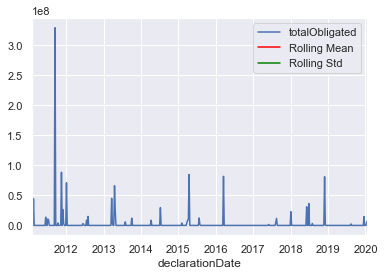

In [167]:
test_stationarity(northeast, 'Severe Storm(s)')

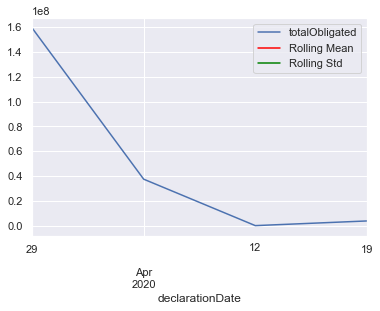

In [168]:
test_stationarity(territory, 'Biological')

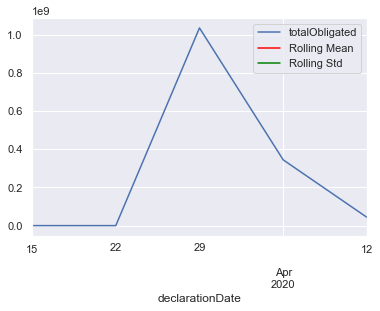

In [169]:
test_stationarity(midwest, 'Biological')

### Insights
---
These plots do not do a good job of showing us the seasonality among disasters for each territory. We will base our modeling and conclusions off of the prior plots from above.

In [170]:
#Reading in data with covid.
df10_covid = pd.read_csv('./data/10-year-covid.csv')
df10_covid.head(3)

,Unnamed: 0,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,totalObligated
0,462426,1952,2011-01-26 05:00:00+00:00,Flood,CBMIB01 - BIA Roads - Emergency Protective Mea...,B - Protective Measures,Small,California,CA,3893.00,2919.75,2919.75
1,462427,1952,2011-01-26 05:00:00+00:00,Flood,LJIRA01 - Debris Removal - 88 Culverts and Veg...,A - Debris Removal,Small,California,CA,45936.76,34452.57,34452.57
2,462428,1952,2011-01-26 05:00:00+00:00,Flood,PBMIE01 - Flood Waters Damaged Casino,E - Public Buildings,Small,California,CA,3263.00,2447.25,2447.25


In [171]:
print(df10_covid['totalObligated'].sum())

85616140218.41


## Modeling Time- Series
---
We will begin with modeling our 10 year covid data. The goal of our model is to predict a budget forcast for the year 2021. We will take aditional steps throughout our modeling to optimize our predictions.

In [14]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
import warnings
import statsmodels.api as sm
import matplotlib.patches as patches

warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [244]:
#setting the index to the date values
df10_covid['declarationDate'] = pd.to_datetime(df10_covid['declarationDate']).dt.date
time_10 = df10_covid.set_index(pd.DatetimeIndex(df10_covid['declarationDate'])).copy()

In [174]:
time_10 = pd.DataFrame(time_10.resample('M')['totalObligated'].sum())

In [245]:
time_10.head(3)

,Unnamed: 0,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,totalObligated
declarationDate,,,,,,,,,,,,
2011-01-26,462426,1952,2011-01-26,Flood,CBMIB01 - BIA Roads - Emergency Protective Mea...,B - Protective Measures,Small,California,CA,3893.00,2919.75,2919.75
2011-01-26,462427,1952,2011-01-26,Flood,LJIRA01 - Debris Removal - 88 Culverts and Veg...,A - Debris Removal,Small,California,CA,45936.76,34452.57,34452.57
2011-01-26,462428,1952,2011-01-26,Flood,PBMIE01 - Flood Waters Damaged Casino,E - Public Buildings,Small,California,CA,3263.00,2447.25,2447.25


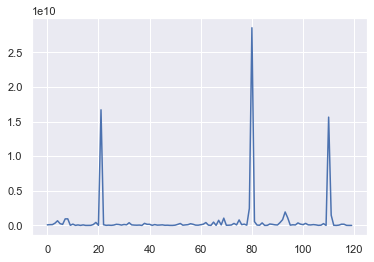

In [176]:
plt.plot(time_10.values);

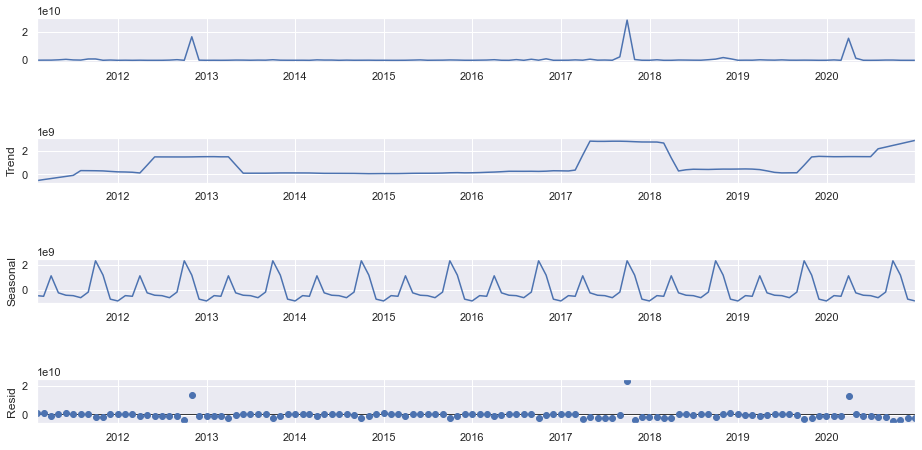

In [177]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(time_10)

#There is no increasing trend from the plots below.


In [178]:
#We see outliers in 2013, 2017 and in 2020. 
#These outliers are:
#2013 - Hurricane Sandy
#2017 - Hurricane Maria, Irma, Harvey
#2020 - COVID!

In [179]:
# Run adfuller test to check for stationarity.
#A portion of this code was adapted from https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
result_10 = adfuller(time_10)

print('ADF Statistic: {}'.format(result_10[0]))
print('p-value: {}'.format(result_10[1]))
print('Critical Values:')
for key, value in result_10[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -10.356153143938634
p-value: 2.4636685565508843e-18
Critical Values:
	1%: -3.4865346059036564
	5%: -2.8861509858476264
	10%: -2.579896092790057


### Stationarity with 10-year data

From the adfuller test above, we can see that there is stationarity. the p-value is far less than 0.05 though the adf statistic is far from the critical values.

In [180]:
# Using function from class to interpret adfuller test.
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [181]:
#More stationarity confirmation
interpret_dftest(result_10)

Test Statistic   -1.035615e+01
p-value           2.463669e-18
dtype: float64

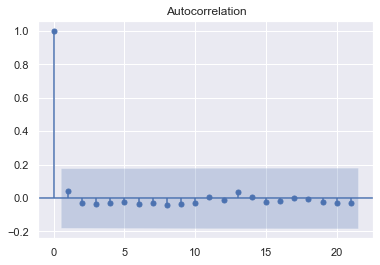

In [182]:
#Our acf and pacf values shows us how well our present data rekates to our past data.
#We would except the acf to show a strong correlation with the recent values, and then it drops off steeply. This is apparent
#in our plots below.
plot_acf(time_10.values);

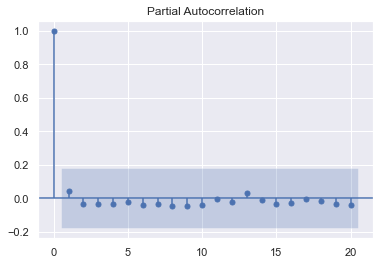

In [183]:
plot_pacf(time_10.values, lags=20);

In [184]:
y_train_10, y_test_10 = train_test_split(time_10['totalObligated'],
                                  test_size=0.2,
                                  random_state=42,
                                  shuffle=False)

In [185]:
#implementing a manual gridserch loop from class to find the best p & q
#Code adapted from lesson 7.03
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# nested for loops to iterate over p and q values
for p in range(5):
    for q in range(5):
        try:
            print(f'Attempting to fit ARIMA({p}, 1, {q})model.')
            
            arima_10 = ARIMA(endog = y_train_10.astype(float).dropna(),
                         order = (p, 1, q))
            
            model_10 = arima_10.fit()
            
            if model_10.aic < best_aic:
                
                best_aic = model_10.aic
                best_p = p
                best_q = q
        except:
            pass
        
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p}, 1, {best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)model.
Attempting to fit ARIMA(0, 1, 1)model.
Attempting to fit ARIMA(0, 1, 2)model.
Attempting to fit ARIMA(0, 1, 3)model.
Attempting to fit ARIMA(0, 1, 4)model.
Attempting to fit ARIMA(1, 1, 0)model.
Attempting to fit ARIMA(1, 1, 1)model.
Attempting to fit ARIMA(1, 1, 2)model.
Attempting to fit ARIMA(1, 1, 3)model.
Attempting to fit ARIMA(1, 1, 4)model.
Attempting to fit ARIMA(2, 1, 0)model.
Attempting to fit ARIMA(2, 1, 1)model.
Attempting to fit ARIMA(2, 1, 2)model.
Attempting to fit ARIMA(2, 1, 3)model.
Attempting to fit ARIMA(2, 1, 4)model.
Attempting to fit ARIMA(3, 1, 0)model.
Attempting to fit ARIMA(3, 1, 1)model.
Attempting to fit ARIMA(3, 1, 2)model.
Attempting to fit ARIMA(3, 1, 3)model.
Attempting to fit ARIMA(3, 1, 4)model.
Attempting to fit ARIMA(4, 1, 0)model.
Attempting to fit ARIMA(4, 1, 1)model.
Attempting to fit ARIMA(4, 1, 2)model.
Attempting to fit ARIMA(4, 1, 3)model.
Attempting to fit ARIMA(4, 1, 4)model.


MODEL FINISHED!
Our mod

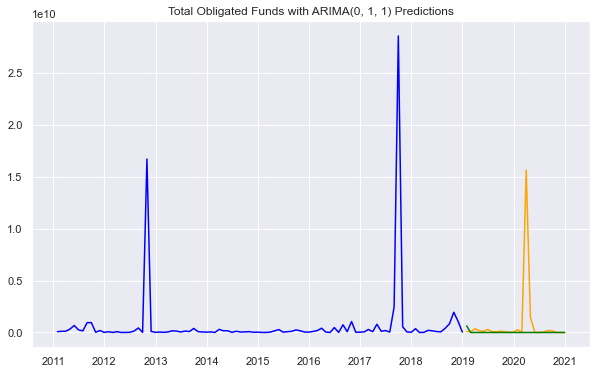

In [186]:
# Instantiate the best model.
model_10 = ARIMA(endog = y_train_10.astype(int).dropna(),
             order = (0, 1, 1))

arima_10 = model_10.fit()

#generating predictions
preds_10 = model_10.predict(params = arima_10.params,
                     start = y_test_10.index[0],
                     end = y_test_10.index[-1])

plt.figure(figsize=(10,6))

#training
plt.plot(y_train_10.index, pd.DataFrame(y_train_10), color='blue')

#testing
plt.plot(y_test_10.index, pd.DataFrame(y_test_10), color='orange')

#predicted testing
plt.plot(y_test_10.index, preds_10, color='green')

plt.title(label = 'Total Obligated Funds with ARIMA(0, 1, 1) Predictions', fontsize=12)
plt.show();

In [187]:
#We have data for every month going back 10 years and we want to 
#forcast the total Obligated funds for the next year (2021).
#We will use (12*10) + (12*1)
res_10 = (12*10) + (12*1)
res_10

132

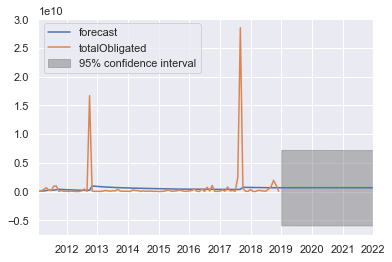

In [188]:
#The 1 represents the view of our data that we want to see. from the start (1) to the end (res=132).
#Below, we are showing our data forecast out to 2021.
arima_10.plot_predict(1, res_10);

In [189]:
#The result of our MSE shows...
#Shows us how far away we are from the result (preds)
mean_squared_error(y_test_10, preds_10, squared=False)

3209883767.1405916

In [190]:
# Same code from in class to test for values of p & q.
# This was made into a function to expand the search for ARIMA optimization.
#We will rerun this to check for a better ARIMA score.
def best_arima(x, y):
    best_aic = 99 * (10 ** 16)
    best_p = 0
    best_q = 0

    # nested for loops to iterate over p and q values
    for p in range(x):
        for q in range(y):
            try:
#                 print(f'Attempting to fit ARIMA({p}, 1, {q})model.')

                arima_10 = ARIMA(endog = y_train_10.astype(float).dropna(),
                             order = (p, 1, q))

                model_10 = arima_10.fit()

                if model_10.aic < best_aic:

                    best_aic = model_10.aic
                    best_p = p
                    best_q = q
            except:
                pass

    print()
    print()
    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p}, 1, {best_q}).')
    print(f'This model has an AIC of {best_aic}.')

In [191]:
# Expanding the range of p & q, looking for a better ARIMA model.
best_arima(11, 11)



MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0, 1, 1).
This model has an AIC of 4447.308775422067.


### Insights for 10 Year COVID Data
---
We see here that after expanding our p and q parameters, our original ARIMA(0,1,1) model is still our best model and we will score on it as such.

In [192]:
# Adapted from: https://machinelearningmastery.com/make-sample-forecasts-arima-python/

forecast_10 = arima_10.forecast(steps=12)[0]
print(forecast_10.astype(float))
print(f'The forecast budget for 2021 is ${round(sum(forecast_10).astype(int)/1000000000, 2)}B')

[6.75427045e+08 6.74973877e+08 6.74520710e+08 6.74067543e+08
 6.73614375e+08 6.73161208e+08 6.72708041e+08 6.72254873e+08
 6.71801706e+08 6.71348539e+08 6.70895371e+08 6.70442204e+08]
The forecast budget for 2021 is $8.08B


## Modeling with a 5 Year Forecast
---
Below, we will create a model with a 5 year forecast - one model including covid and the other model excluding covid. We will use this to view the difference in funding based on Covid's impact.

### Modeling Data for 5-Years with COVID removed.

In [193]:
#Reading in 5 year no covid data
df_5 = pd.read_csv('./data/disaster_5_year_no_covid.csv')
df_5.head(1)

,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,totalObligated
0,3376,2016-02-05 05:00:00+00:00,Flood,MIL001B Statewide Emergency Protective Measures,B - Protective Measures,Large,Louisiana,LA,568635.42,426476.57,426476.57


In [194]:
df_5 = df_5.loc[~df_5['incidentType'].str.contains('Biological')]

In [195]:
# Remove any states that were not obligated to any federal money
df_5 =df_5.loc[df_5['federalShareObligated'] != 0.00].copy()

In [196]:
# https://stackoverflow.com/q/51287504
df_5['declarationDate'] = pd.to_datetime(df_5['declarationDate']).dt.date
df_5.head(1)

,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,totalObligated
0,3376,2016-02-05,Flood,MIL001B Statewide Emergency Protective Measures,B - Protective Measures,Large,Louisiana,LA,568635.42,426476.57,426476.57


In [197]:
(df_5['totalObligated']).sum()

43563150685.75001

In [198]:
df_5.head()

,disasterNumber,declarationDate,incidentType,applicationTitle,damageCategoryCode,projectSize,state,stateCode,projectAmount,federalShareObligated,totalObligated
0,3376,2016-02-05,Flood,MIL001B Statewide Emergency Protective Measures,B - Protective Measures,Large,Louisiana,LA,568635.42,426476.57,426476.57
2,3376,2016-02-05,Flood,WFS001B Emergency Protective Measure,B - Protective Measures,Small,Louisiana,LA,5971.53,4478.65,4478.65
3,3376,2016-02-05,Flood,BER001B Emergency Protective Measures,B - Protective Measures,Small,Louisiana,LA,11093.97,8320.48,8320.48
4,3376,2016-02-05,Flood,PPG001B Emergency Protective Measures,B - Protective Measures,Large,Louisiana,LA,130848.95,98136.71,98136.71
5,3376,2016-02-05,Flood,MOR001B Emergency Protective Measures,B - Protective Measures,Small,Louisiana,LA,21467.59,16100.69,16100.69


In [199]:
time_5 = pd.read_csv('./resample.csv')
time_5 = time_5.set_index(pd.DatetimeIndex(time_5['declarationDate']))
time_5 = time_5.drop(columns = ['declarationDate'], axis=1)
time_5.head(1)

,totalObligated
declarationDate,
2016-01-31,1.028938e+08


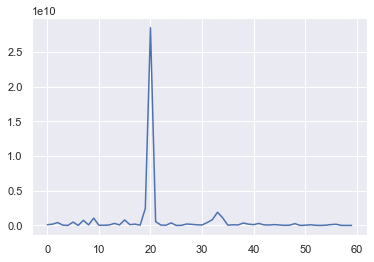

In [200]:
plt.plot(time_5.values);

In [201]:
# Run adfuller test to check for stationarity.
adfuller(time_5)

(-7.0144699848425835,
 6.788640433008347e-10,
 0,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 2263.8198114546394)

In [202]:
# Using function from class to interpret adfuller test.
# Code written by Joseph Nelson.

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [203]:
interpret_dftest(adfuller(time_5))

Test Statistic   -7.014470e+00
p-value           6.788640e-10
dtype: float64

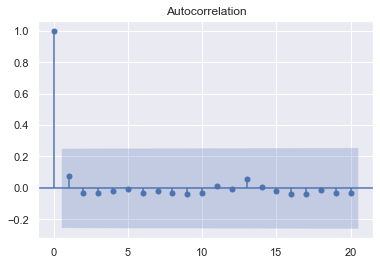

In [204]:
plot_acf(time_5.values, lags=20);

In [205]:
y_train_5, y_test_5 = train_test_split(time_5['totalObligated'],
                                  test_size=0.2,
                                  random_state=42,
                                  shuffle=False)

In [206]:
# loop from class to find best p & q
# np.random.seed(42)
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# nested for loops to iterate over p and q values
for p in range(5):
    for q in range(5):
        try:
            print(f'Attempting to fit ARIMA({p}, 1, {q})model.')
            
            arima_5 = ARIMA(endog = y_train_5.astype(float).dropna(),
                         order = (p, 1, q))
            
            model_5 = arima_5.fit()
            
            if model_5.aic < best_aic:
                
                best_aic = model_5.aic
                best_p = p
                best_q = q
        except:
            pass
        
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p}, 1, {best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)model.
Attempting to fit ARIMA(0, 1, 1)model.
Attempting to fit ARIMA(0, 1, 2)model.
Attempting to fit ARIMA(0, 1, 3)model.
Attempting to fit ARIMA(0, 1, 4)model.
Attempting to fit ARIMA(1, 1, 0)model.
Attempting to fit ARIMA(1, 1, 1)model.
Attempting to fit ARIMA(1, 1, 2)model.
Attempting to fit ARIMA(1, 1, 3)model.
Attempting to fit ARIMA(1, 1, 4)model.
Attempting to fit ARIMA(2, 1, 0)model.
Attempting to fit ARIMA(2, 1, 1)model.
Attempting to fit ARIMA(2, 1, 2)model.
Attempting to fit ARIMA(2, 1, 3)model.
Attempting to fit ARIMA(2, 1, 4)model.
Attempting to fit ARIMA(3, 1, 0)model.
Attempting to fit ARIMA(3, 1, 1)model.
Attempting to fit ARIMA(3, 1, 2)model.
Attempting to fit ARIMA(3, 1, 3)model.
Attempting to fit ARIMA(3, 1, 4)model.
Attempting to fit ARIMA(4, 1, 0)model.
Attempting to fit ARIMA(4, 1, 1)model.
Attempting to fit ARIMA(4, 1, 2)model.
Attempting to fit ARIMA(4, 1, 3)model.
Attempting to fit ARIMA(4, 1, 4)model.


MODEL FINISHED!
Our mod

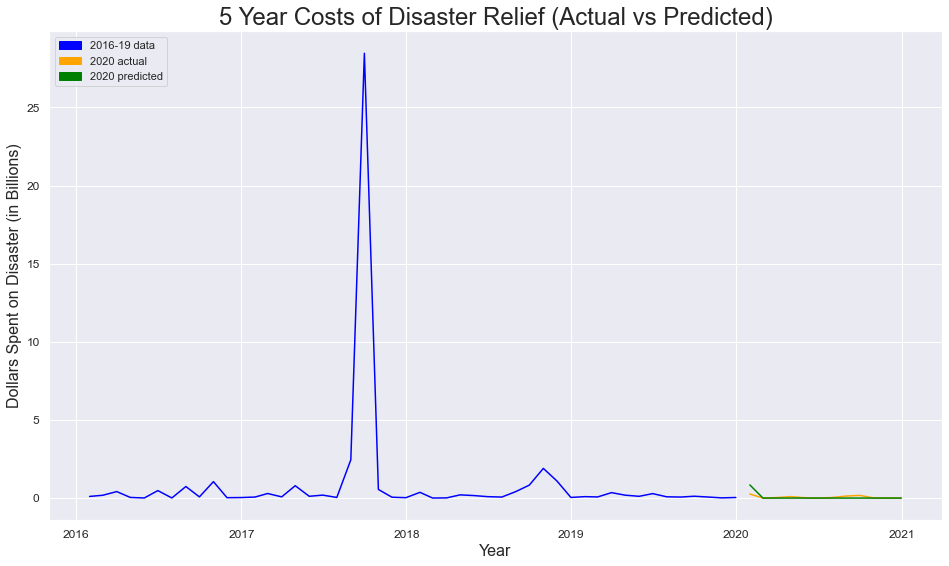

In [207]:
# Instantiate the best model.
# This plot and legend was adapted from 
model_5 = ARIMA(endog = y_train_5.astype(int).dropna(),
             order = (0, 1, 1))

arima_5 = model_5.fit()

preds_5 = model_5.predict(params = arima_5.params,
                     start = y_test_5.index[0],
                     end = y_test_5.index[-1])

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(y_train_5.index, pd.DataFrame(y_train_5), color='blue')

ax.plot(y_test_5.index, pd.DataFrame(y_test_5), color='orange')

ax.plot(y_test_5.index, preds_5, color='green')

ax.tick_params(axis='x', labelsize=12)
ax.set_yticklabels(['0', '0', '5', '10', '15', '20', '25'], size=12)
ax.set_ylabel('Dollars Spent on Disaster (in Billions)', size=16)
ax.set_xlabel('Year', size=16)
ax.set_title('5 Year Costs of Disaster Relief (Actual vs Predicted)', size=24)
blue_patch = patches.Patch(color='blue', label='2016-19 data')
orange_patch = patches.Patch(color='orange', label='2020 actual')
green_patch = patches.Patch(color='green', label='2020 predicted')
plt.legend(handles=[blue_patch, orange_patch, green_patch], loc='upper left')

plt.show();

In [208]:
#Our root mean squared error for 5-year-no-covid is lower than our 10-year-covid data.
#This means we are closer to our actuals.
mean_squared_error(y_test_5, preds_5, squared=False)

181454311.8352157

In [209]:
# Same code from in class to test for values of p & q.
# Made into a function to expand the search for optimization.
def best_arima(x, y):
    best_aic = 99 * (10 ** 16)
    best_p = 0
    best_q = 0

    # nested for loops to iterate over p and q values
    for p in range(x):
        for q in range(y):
            try:
#                 print(f'Attempting to fit ARIMA({p}, 1, {q})model.')

                arima_5 = ARIMA(endog = y_train_5.astype(float).dropna(),
                             order = (p, 1, q))

                model_5 = arima_5.fit()

                if model_5.aic < best_aic:

                    best_aic = model_5.aic
                    best_p = p
                    best_q = q
            except:
                pass

    print()
    print()
    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p}, 1, {best_q}).')
    print(f'This model has an AIC of {best_aic}.')

In [210]:
# Expanding the range of p & q, looking for a better ARIMA model.
best_arima(11, 11)



MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0, 1, 1).
This model has an AIC of 2223.6890222792917.


### Arima Search Result - 5 Year without COVID
We see here that after expanding our p and q parameters, our original ARIMA(0,1,1) model is still our best model and we will score on it as such.

In [211]:
# Adapted from: https://machinelearningmastery.com/make-sample-forecasts-arima-python/

forecast_5 = arima_5.forecast(steps=12)[0]
print(forecast_5.astype(float))
print(f'The forecast budget for 2021 is ${round(sum(forecast_5).astype(int)/1000000000, 2)}B')

[8.74194335e+08 8.72746931e+08 8.71299528e+08 8.69852124e+08
 8.68404721e+08 8.66957317e+08 8.65509914e+08 8.64062510e+08
 8.62615107e+08 8.61167703e+08 8.59720300e+08 8.58272897e+08]
The forecast budget for 2021 is $10.39B


In [212]:
pd.DataFrame(time_5.resample('Y')['totalObligated'].sum().astype(int))

,totalObligated
declarationDate,
2016-12-31,3133120255
2017-12-31,33091179200
2018-12-31,5152341050
2019-12-31,1447786105
2020-12-31,738639797


#### Resampling with 5 year COVID data.

In [213]:
covid = pd.read_csv('./data/disaster_5_year_with_covid.csv')

In [214]:
covid['declarationDate'] = pd.to_datetime(covid['declarationDate']).dt.date
comp = covid.set_index(pd.DatetimeIndex(covid['declarationDate'])).copy()
comp = pd.DataFrame(comp.resample('Y')['totalObligated'].sum().astype(int))
comp

,totalObligated
declarationDate,
2016-12-31,3133120255
2017-12-31,33091179200
2018-12-31,5152341050
2019-12-31,1447786105
2020-12-31,16811381902


### Insights
---

In our dataset with all COVID related costs removed, we can see that a large portion of the FEMA budget was reallocated to COVID measures. We see a strong dip in costs from 2019 to 2020, from approximately \\$1.44B in 2019 to only \\$738M in 2020. 

The reallocation is confirmed when we look at the comparison dataset above, with COVID features intact. Despite removing the COVID data for a "best-case-scenario," the arima model still forecasts over \\$10B and upon a closer look, it seems the prior costs were inflated. 

This was due to a spike in 2017 recovery costs , which - after some research - is attributed to Hurricanes Irma, Maria, and Harvey. These specific hurricanes ravaged the Gulf States and territories of the Caribbean through late August and September of 2017. 

In [215]:
res_5 = (12 * 5) + (12)
res_5

72

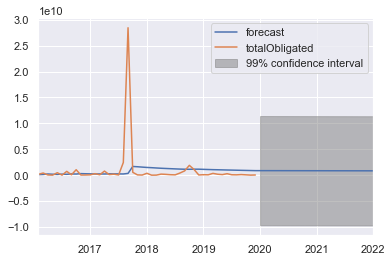

In [216]:
arima_5.plot_predict(1, res_5, alpha=0.01);

## Arima 5 Year Covid Model

In [16]:
df_5_covid = pd.read_csv('./data/disaster_5_year_with_covid.csv')

In [17]:
df_5_covid  = df_5_covid.loc[df_5_covid ['federalShareObligated'] != 0.00].copy()

In [18]:
df_5_covid['declarationDate'] = pd.to_datetime(df_5_covid['declarationDate']).dt.date
time_covid = df_5_covid.set_index(pd.DatetimeIndex(df_5_covid['declarationDate'])).copy()

In [19]:
time_covid = pd.DataFrame(time_covid.resample('M')['totalObligated'].sum())

In [248]:
time_covid.tail(12)

,totalObligated
declarationDate,
2020-01-31,2.575680e+08
2020-02-29,0.000000e+00
2020-03-31,1.478449e+10
2020-04-30,1.409537e+09
2020-05-31,2.130765e+07
2020-06-30,2.236056e+05
2020-07-31,3.442857e+07
2020-08-31,1.257620e+08
2020-09-30,1.690273e+08


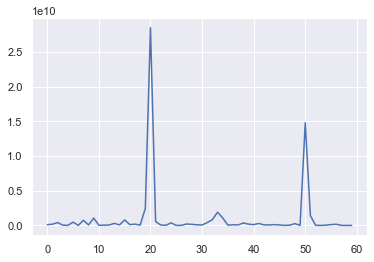

In [226]:
plt.plot(time_covid.values);

In [227]:
# Run adfuller test to check for stationarity.
#A portion of this code was adapted from https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
result = adfuller(time_covid)

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -7.168432831930448
p-value: 2.845881922870424e-10
Critical Values:
	1%: -3.5463945337644063
	5%: -2.911939409384601
	10%: -2.5936515282964665


In [228]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput
interpret_dftest(adfuller(time_covid))

Test Statistic   -7.168433e+00
p-value           2.845882e-10
dtype: float64

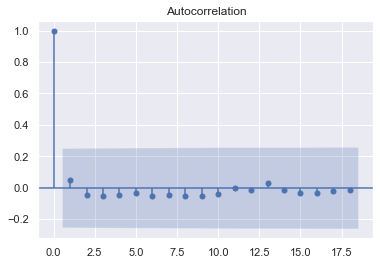

In [229]:
plot_acf(time_covid.values);

In [20]:
y_train_covid, y_test_covid = train_test_split(time_covid['totalObligated'],
                                  test_size=0.2,
                                  random_state=42,
                                  shuffle=False)

In [231]:

best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# nested for loops to iterate over p and q values
for p in range(5):
    for q in range(5):
        try:
            print(f'Attempting to fit ARIMA({p}, 1, {q})model.')
            
            arima_covid = ARIMA(endog = y_train_covid.astype(float).dropna(),
                         order = (p, 1, q))
            
            model_covid = arima_covid.fit()
            
            if model_covid.aic < best_aic:
                
                best_aic = model_covid.aic
                best_p = p
                best_q = q
        except:
            pass
        
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p}, 1, {best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)model.
Attempting to fit ARIMA(0, 1, 1)model.
Attempting to fit ARIMA(0, 1, 2)model.
Attempting to fit ARIMA(0, 1, 3)model.
Attempting to fit ARIMA(0, 1, 4)model.
Attempting to fit ARIMA(1, 1, 0)model.
Attempting to fit ARIMA(1, 1, 1)model.
Attempting to fit ARIMA(1, 1, 2)model.
Attempting to fit ARIMA(1, 1, 3)model.
Attempting to fit ARIMA(1, 1, 4)model.
Attempting to fit ARIMA(2, 1, 0)model.
Attempting to fit ARIMA(2, 1, 1)model.
Attempting to fit ARIMA(2, 1, 2)model.
Attempting to fit ARIMA(2, 1, 3)model.
Attempting to fit ARIMA(2, 1, 4)model.
Attempting to fit ARIMA(3, 1, 0)model.
Attempting to fit ARIMA(3, 1, 1)model.
Attempting to fit ARIMA(3, 1, 2)model.
Attempting to fit ARIMA(3, 1, 3)model.
Attempting to fit ARIMA(3, 1, 4)model.
Attempting to fit ARIMA(4, 1, 0)model.
Attempting to fit ARIMA(4, 1, 1)model.
Attempting to fit ARIMA(4, 1, 2)model.
Attempting to fit ARIMA(4, 1, 3)model.
Attempting to fit ARIMA(4, 1, 4)model.


MODEL FINISHED!
Our mod

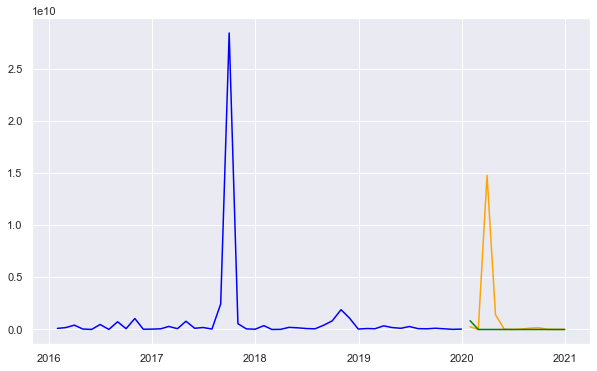

In [234]:
# Instantiate the best model.
model_covid = ARIMA(endog = y_train_covid.astype(float).dropna(),
             order = (0, 1, 1))

arima_covid = model_covid.fit()

preds_covid = model_covid.predict(params = arima_covid.params,
                     start = y_test_covid.index[0],
                     end = y_test_covid.index[-1])

plt.figure(figsize=(10,6))

plt.plot(y_train_covid.index, pd.DataFrame(y_train_covid), color='blue')

plt.plot(y_test_covid.index, pd.DataFrame(y_test_covid), color='orange')

plt.plot(y_test_covid.index, preds_covid, color='green')

plt.show();

In [235]:
#Our root mean squared error for 5-year-with-covid is higher than our 10-year-covid data.
#This means we are further from our actuals.
mean_squared_error(y_test_covid, preds_covid, squared=False)

4291467080.306944

In [145]:
# Same code from in class to test for values of p & q.
# Made into a function to expand the search for optimization.
def best_arima_covid(x, y):
    best_aic = 99 * (10 ** 16)
    best_p = 0
    best_q = 0

    # nested for loops to iterate over p and q values
    for p in range(x):
        for q in range(y):
            try:
#                 print(f'Attempting to fit ARIMA({p}, 1, {q})model.')

                arima_covid = ARIMA(endog = y_train_covid.astype(float).dropna(),
                             order = (p, 1, q))

                model_covid = arima_covid.fit()

                if model_covid.aic < best_aic:

                    best_aic = model.aic
                    best_p = p
                    best_q = q
            except:
                pass

    print()
    print()
    print('MODEL FINISHED!')
    print('-------------------------------------\n')
    print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p}, 1, {best_q}).')
    print('-------------------------------------\n')
    print(f'This model has an AIC of {best_aic}.')
    print('-------------------------------------\n')
    print(model.summary())

In [146]:
best_arima_covid(11, 11)



MODEL FINISHED!
-------------------------------------

Our model that minimizes AIC on the training data is the ARIMA(0, 1, 1).
-------------------------------------

This model has an AIC of 2223.6890222792917.
-------------------------------------

                             ARIMA Model Results                              
Dep. Variable:       D.totalObligated   No. Observations:                   47
Model:                ARIMA(10, 1, 2)   Log Likelihood               -1108.565
Method:                       css-mle   S.D. of innovations     4060604401.509
Date:                Wed, 24 Mar 2021   AIC                           2245.130
Time:                        20:33:39   BIC                           2271.032
Sample:                    02-29-2016   HQIC                          2254.877
                         - 12-31-2019                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

In [241]:
# Adapted from: https://machinelearningmastery.com/make-sample-forecasts-arima-python/

forecast_covid = arima_covid.forecast(steps=12)[0]

print(f'The forecast budget for 2021 is: ${round(sum(forecast_covid)/1000000000, 2)}B')

The forecast budget for 2021 is: $10.39B


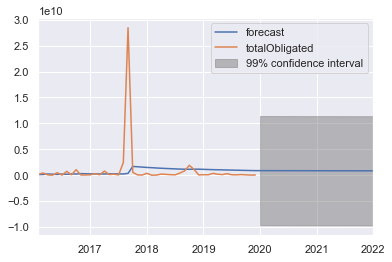

In [29]:
#We want to plot 1 year into the future, so we calculated our res to be
#72
res_covid = (12*5) + (12)

arima_covid.plot_predict(1, res_covid, alpha=0.01);
sns.set(font_scale = .5)


## Conclusion and Recommendations

*What was the impact of covid? 1x, 2x, 5x, the budget?*

Contrary to what we intially believed, the impact of Covid actually had little variation on the budget (if any) for both 5 year datasets. After analyzing our 5 year results, we can conclude that this was due to the amount of training data that was used, along with the fact that Covid was a small portion of the total funds obligated during the 5 year time frame.
During these 5 years, a multitude of hurricanes and other catestrophic disasters happened, causing spikes in spending data. These spikes thus affected the impact of Covid, softening it, despite the vast amount spent on just 2020 (Biological data) alone.


The impact of Covid was not a true multiplier at all. In comparison to the 10 year (+Covid) dataset, both 5 year datasets exceeded the forecast budget by over $2 Billion. This estimation was expected given that the training data for the 10-year forecast gave a longer snapshot of spending history. With more dips in the spending than spikes, the model had room to even out the projected cost of relief aid for the year of 2021. The pattern of spending is reflected in the seasonality plot shown previously.

Both 5 year datasets estimated a budget of roughly .25 percent above the 10 year dataset. Initially, it was hypothesized that Covid would have a larger impact, but this is not the case by any means. It is also important to note that there were no other extremely detrimental disasters in 2020. To clarify, there were disasters, however, their impact in comparison to previous years, was smaller. This was possibly a factor in the budget predictions, given that there were no compounding events to increase the spending in 2020. Had Covid happened in a year like 2013 (along with Hurricane Harvey, Irma and Maria), the spending for that year would have been much higher, thus pushing the forecasted budget of 2021 up.

In conclusion, yes, we were able to build a model that optimized FEMA budget predictions for the year of 2021, however, the predicted outcome including covid vs the outcome without covid was ultimately the same. 

### Recommendations
---
Covid did change the landscape of disasters and how we handle them, but it was not significant enough for us to see how much the budget could increase in 2021 and beyond. In order to get a better prediction for future budgets, modeling different compounded disasters could give a better idea of what the budget should be set at.

Adding an additional $2Billion dollars (the difference in predicted funds) is best as an extra cushion for a year with compounded disaster events. This is especially important given the increase in climate change and the effects of it on the weather.

Training on more data from the past could also show us the trend in budget increases throughout the years. We could then use this to project how much money we would be allocating for the future populations of the US and territiories.

Introducing new/ other data into the model could also give insight to deviations in spending throughout the 10 years.